In [1]:
import time
import random
import heapq as hp
import gym
import numpy as np
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from pandas.tools.plotting import scatter_matrix
%matplotlib inline

Using TensorFlow backend.


In [2]:
class DQNAgent:
    def __init__(self, state_size, action_size,epsilon_decay = 0.99,gamma=0.95):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = {}
        self.pqt=[]
        self.gamma = 0.95   # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.99
        self.learning_rate = 0.001  # the learning rate
        self.model = self._build_model() # Current model
        self.pev_model=self.model        # Previous model
        
    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse',
                      optimizer=Adam(lr=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        cort_rwd=(reward + self.gamma *
                          np.amax(self.pev_model.predict(next_state)[0]))
        prd_rwd=self.pev_model.predict(next_state)[0][action]
        hp.heappush(self.pqt,-abs(float(cort_rwd - prd_rwd)))
        self.memory[-abs(float(cort_rwd - prd_rwd))]=(state, action, reward, next_state, done)
        
        
        
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])  # returns action
    
    def replay(self, batch_size):
        
        for _ in range(batch_size):
            
            state, action, reward, next_state, done = self.memory[hp.heappop(self.pqt)]
            target = reward
            if not done:
                target = (reward + self.gamma *
                          np.amax(self.pev_model.predict(next_state)[0]))  # q(s,a) = r + max(q(_s,_a)) over _a
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)


In [58]:
# After 500 time steps the game automaticly terminates

EPISODES = 1000
result = []

def run():
    env = gym.make('CartPole-v1')
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    time_start=time.time()
    
    agent = DQNAgent(state_size, action_size)
   
    done = False
    batch_size = 32
    vally=0 # Counter for success
    for e in range(EPISODES):
        timestep = 0
        done=False
        state = env.reset() 
        state = np.reshape(state, [1, state_size]) # Encapsulating whole thing into array i.e [[1,12,2,3]]
        while not done:     
            timestep+=1
           # env.render() Run it on your local machine
            action = agent.act(state)
            next_state, reward, done, info = env.step(action)
            '''
            Problem in Code (1)
            '''
            reward = reward if not done else -10 # Even after completing the task successfully agent got -ve reward ; Logical error
            next_state = np.reshape(next_state, [1, state_size])
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            '''
            Problem in Code (2)
            '''
            agent.pev_model=agent.model # LoL LoL... Dude it's python
            if done:
                result.append(timestep)
                '''
                print("episode: {}/{}, score: {}, e: {:.2}"
                      .format(e, EPISODES, timestep, agent.epsilon))
                '''
                break
        if timestep>=499 : 
            vally+=1
            print("Time for which pole stand:",e,vally)
            if vally==20:
                break
                print("Done after episode:",e-1)
        if len(agent.pqt) > batch_size:
            agent.replay(batch_size)
    end_time=time.time()
    print(end_time-time_start)
    return agent


In [59]:
agent = run()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Time for which pole stand: 244 1
Time for which pole stand: 272 2
Time for which pole stand: 273 3
Time for which pole stand: 299 4
Time for which pole stand: 304 5
Time for which pole stand: 319 6
Time for which pole stand: 339 7
Time for which pole stand: 598 8
Time for which pole stand: 671 9
Time for which pole stand: 680 10
Time for which pole stand: 683 11
Time for which pole stand: 684 12
Time for which pole stand: 685 13
Time for which pole stand: 699 14
Time for which pole stand: 713 15
Time for which pole stand: 769 16
Time for which pole stand: 771 17
Time for which pole stand: 773 18
Time for which pole stand: 774 19
1888.1970958709717


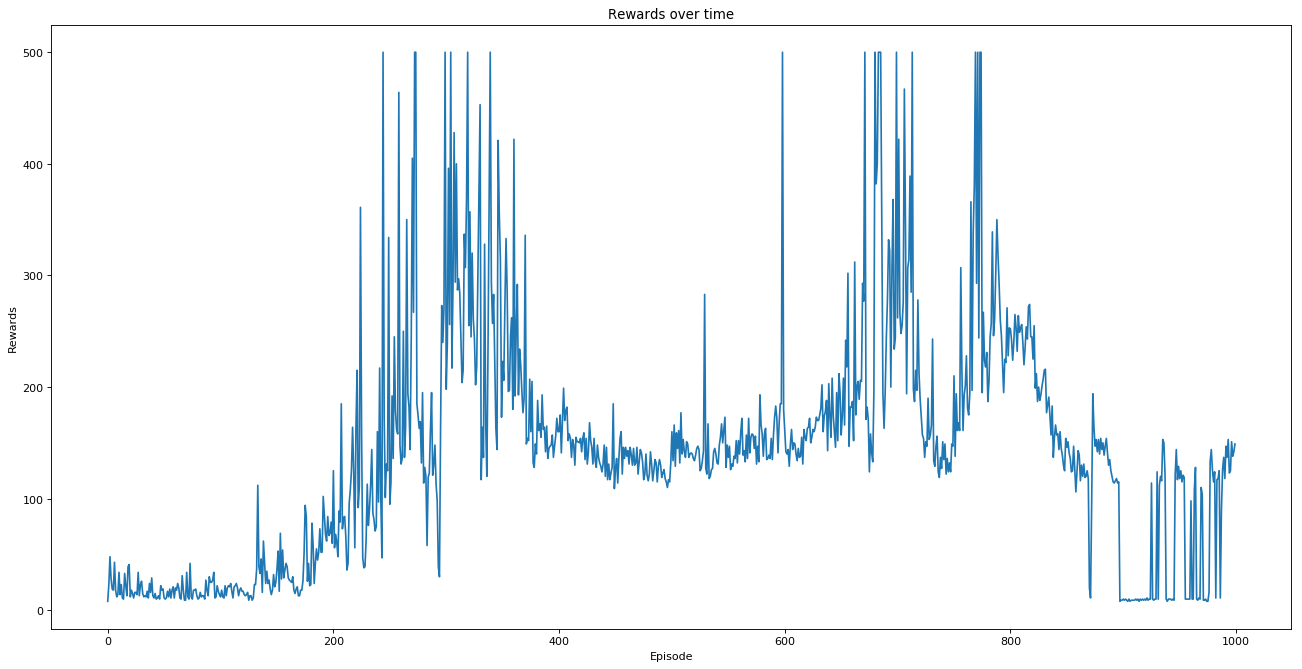

In [60]:
import matplotlib.pyplot as plt

plt.figure(num=None, figsize=(20,10), dpi=80, facecolor='w', edgecolor='k')

plt.plot(result)
plt.xlabel('Episode')
plt.ylabel('Rewards')
plt.title('Rewards over time')
#plt.savefig("./cartpole_ddqn.png")

plt.show()

## Some observation:
Performance of agent if not consistent 

In [64]:
def policy_evaluation(env,agent):
    avg=0
    lst=[]
    for i in range(100):
        #env.seed(i)
        state=env.reset()
        state=np.reshape(state,[1,agent.state_size])
        action=np.argmax(agent.model.predict(state)[0])
        nxt_state, reward, done, info = env.step(action)
        net_r=0
        
        while not done:
            net_r+=reward
            state=nxt_state
            state=np.reshape(state, [1,agent.state_size])
            action=np.argmax(agent.model.predict(state)[0])
            nxt_state, reward, done, info = env.step(action)
            #print(nxt_state, reward, done)
            
        
        avg+=net_r
        print("Reward for {} episode: {}".format(i,net_r))
        lst.append(net_r)
    print("Avg reward: ",avg/(i+1) )
    print("Variance Score :",np.var(lst))
    env.close()
    return lst

In [65]:
env = gym.make('CartPole-v1')
result = policy_evaluation(env,agent)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Reward for 0 episode: 127.0
Reward for 1 episode: 157.0
Reward for 2 episode: 153.0
Reward for 3 episode: 145.0
Reward for 4 episode: 161.0
Reward for 5 episode: 154.0
Reward for 6 episode: 132.0
Reward for 7 episode: 146.0
Reward for 8 episode: 135.0
Reward for 9 episode: 130.0
Reward for 10 episode: 134.0
Reward for 11 episode: 132.0
Reward for 12 episode: 132.0
Reward for 13 episode: 135.0
Reward for 14 episode: 143.0
Reward for 15 episode: 139.0
Reward for 16 episode: 139.0
Reward for 17 episode: 160.0
Reward for 18 episode: 148.0
Reward for 19 episode: 171.0
Reward for 20 episode: 145.0
Reward for 21 episode: 152.0
Reward for 22 episode: 142.0
Reward for 23 episode: 134.0
Reward for 24 episode: 139.0
Reward for 25 episode: 129.0
Reward for 26 episode: 145.0
Reward for 27 episode: 144.0
Reward for 28 episode: 139.0
Reward for 29 episode: 152.0
Reward for 30 episode: 145.0
Reward for 3

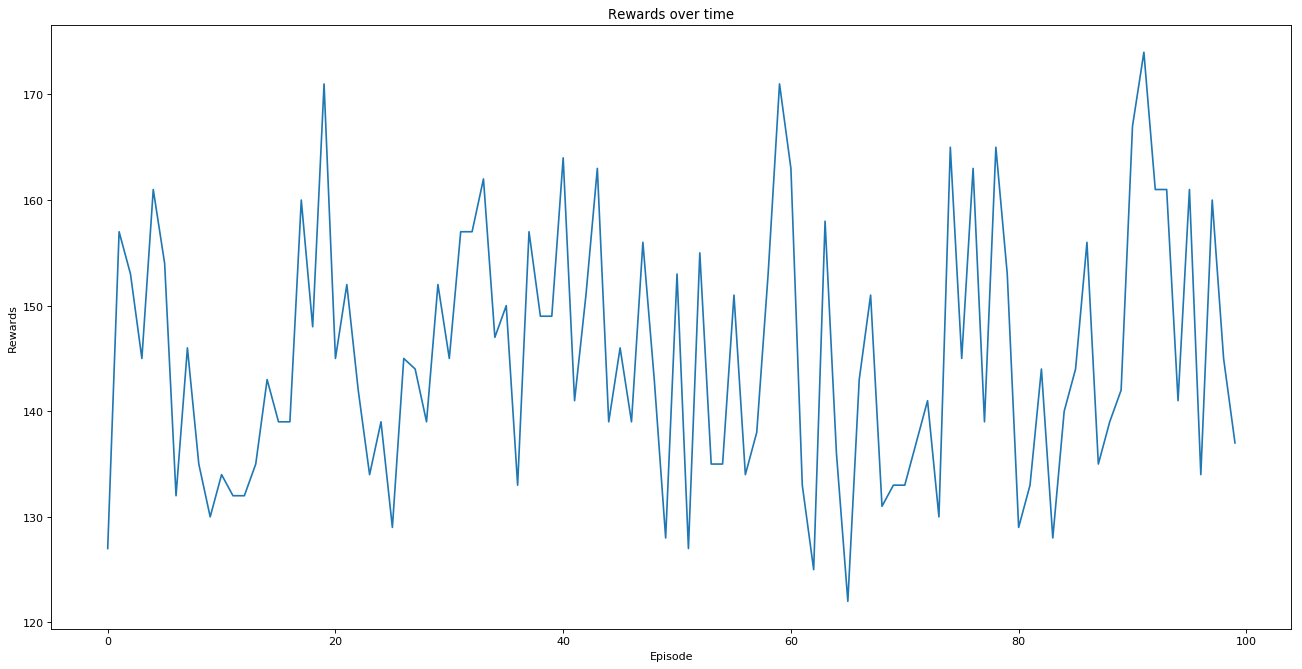

In [66]:
import matplotlib.pyplot as plt

plt.figure(num=None, figsize=(20,10), dpi=80, facecolor='w', edgecolor='k')

plt.plot(result)
plt.xlabel('Episode')
plt.ylabel('Rewards')
plt.title('Rewards over time')
#plt.savefig("./cartpole_ddqn.png")

plt.show()

## Let's begin the experiment

In [7]:


def do_it(agent):
    env.reset()
    time_start=time.time()
    
    
    # agent.load("./save/cartpole-dqn.h5")
    done = False
    batch_size = 32
    vally=[]   # List of episode in which agent complete sucess.
    for e in range(EPISODES):

        done=False
        state = env.reset()  
        state = np.reshape(state, [1, state_size]) # Encapsulating whole thing into and array i.e [[1,12,2,3]]
        for t in range(500):    
            
          #  env.render() 
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            reward = reward if not done else -10
            next_state = np.reshape(next_state, [1, state_size])
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            agent.pev_model=agent.model
            if done:
               # print("episode: {}/{}, score: {}, e: {:.2}"
                #      .format(e, EPISODES, t, agent.epsilon))
                break
        if t>=499 : 
            vally.append(e-1)
            #print("Time for which pole stand:",t,vally)
            if len(vally)==10:
                break
                
        if len(agent.pqt) > batch_size:
            agent.replay(batch_size)
    end_time=time.time()
    
    
    #Time to test agent
    
    avg=0
    
    for i in range(100):
        #env.seed(i)
        state=env.reset()
        state=np.reshape(state,[1,agent.state_size])
        action=np.argmax(agent.model.predict(state)[0])
        nxt_state, reward, done, info = env.step(action)
        net_r=0
        while not done:
            net_r+=reward
            state=nxt_state
            state=np.reshape(state, [1,agent.state_size])
            action=np.argmax(agent.model.predict(state)[0])
            nxt_state, reward, done, info = env.step(action)
            #print(nxt_state, reward, done)
        avg+=net_r
        #print("Reward for {} episode: {}".format(i,net_r))
    
    agent.memory.clear()
    agent.pqt.clear()
    
    return([end_time-time_start, vally, avg/(i+1), agent])
        # if e % 10 == 0:
#     agent.save("./save/cartpole-dqn.h5")

In [8]:
#Set some hyperparameters gamma, epsilon_decay
gammaLst=[0.8,0.85,0.9,0.95,1]
epsilon_decayLst=[0.5,0.7,0.8,0.9,0.95,0.98,0.985,0.99,0.995]

## Make agents

In [9]:
env = gym.make('CartPole-v1')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent_hyp=[]
for i in range(len(gammaLst)):
    agent_gamma=[]
    for j in range(len(epsilon_decayLst)):
        final=[]
        for po in range(3):
            final.append(DQNAgent(state_size, action_size,epsilon_decayLst[j],gammaLst[i]))
        agent_gamma.append(final)
    agent_hyp.append(agent_gamma)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


## Test all 135 agents

In [10]:
agent_hyp_perf=[]
for i in range(len(gammaLst)):
    agent_gamma_perf=[]
    for j in range(len(epsilon_decayLst)):
        finl_perf=[]
        for po in range(3):
            finl_perf.append(do_it(agent_hyp[i][j][po]))
        agent_gamma_perf.append([[epsilon_decayLst[j],gammaLst[i]],finl_perf])
    agent_hyp_perf.append(agent_gamma_perf)
    print("Done for gamma : ",gammaLst[i])


Done for gamma :  0.8
Done for gamma :  0.85
Done for gamma :  0.9
Done for gamma :  0.95
Done for gamma :  1


## Analysis

In [46]:
agent_hyp_perf[0][0]

[[0.5, 0.8],
 [[97.44294261932373,
   [189, 195, 199, 201, 203, 205, 206, 208, 213, 214],
   493.91,
  [402.89475750923157,
   [356, 439, 543, 544, 567, 578, 614, 627, 628, 636],
   429.29,
  [291.524729013443,
   [419, 425, 427, 443, 510, 520, 522, 526, 530, 536],
   307.58,

In [37]:
vally_s = [] #List of vally of every agent
Score = []  # List of Average score of every agent
timeTaken = []

for i in range(len(gammaLst)):
    for j in range(len(epsilon_decayLst)):
        for k in range(3):
            Score.append(agent_hyp_perf[i][j][1][k][2])
            vally_s.append(agent_hyp_perf[i][j][1][k][1])
            timeTaken.append(agent_hyp_perf[i][j][1][k][0])
            while len(vally_s[-1])!=10:         #If the agent can't achive it's goal for 10 time then append 1000 to vally of that agent
                vally_s[-1].append(1000)
                

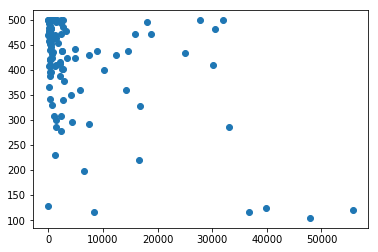

In [35]:
agentVarience = [np.var(vally) for vally in vally_s] # Variance of episode in which agent score perfect 500 score

plt.scatter(x=agentVarience, y=Score)

In [41]:
np.corrcoef(x=agentVarience, y=Score)

array([[ 1.        , -0.51065297],
       [-0.51065297,  1.        ]])

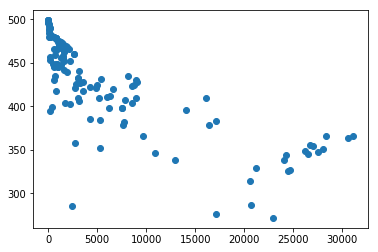

In [36]:
varScore = [] #Variance of Score of agent having same hyperparameters
avgScore = [] # Average of Score of agent having same hyperparameters

for i in range(len(Score)): # len(avgScore) = 135
    varScore.append(np.var(Score[i:i+3]))  
    avgScore.append(np.mean(Score[i:i+3])) 

plt.scatter(x=varScore, y=avgScore)

In [42]:
np.corrcoef(x=varScore, y=avgScore)

array([[ 1.        , -0.78377201],
       [-0.78377201,  1.        ]])

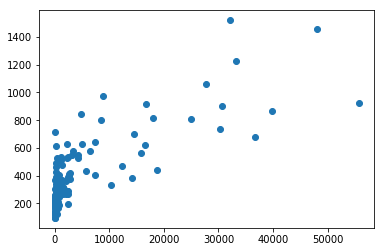

In [39]:
plt.scatter(x=agentVarience, y=timeTaken)

In [40]:
np.corrcoef(x=agentVarience, y=timeTaken)

array([[1.        , 0.78480415],
       [0.78480415, 1.        ]])

# Observation :
* Most of the time for high Score, agentVarience is less.
* Most of the time for high avgScore, varAvgScore is less.
* The one with the more agentVarience took more time.
* For same hyperparameter agent Score are differnet.

# Conclusion :
* agentVarience should be less for proper convergence.
* varAvgScore should be less for proper convergence.
* The agent is getting a negative reward even after completing the goal, maybe due to this agent is not converging properly.